正在加载数据...
正在计算路径转向特征...
正在进行 KDTree 匹配并计算距离误差...
正在生成可视化图表...


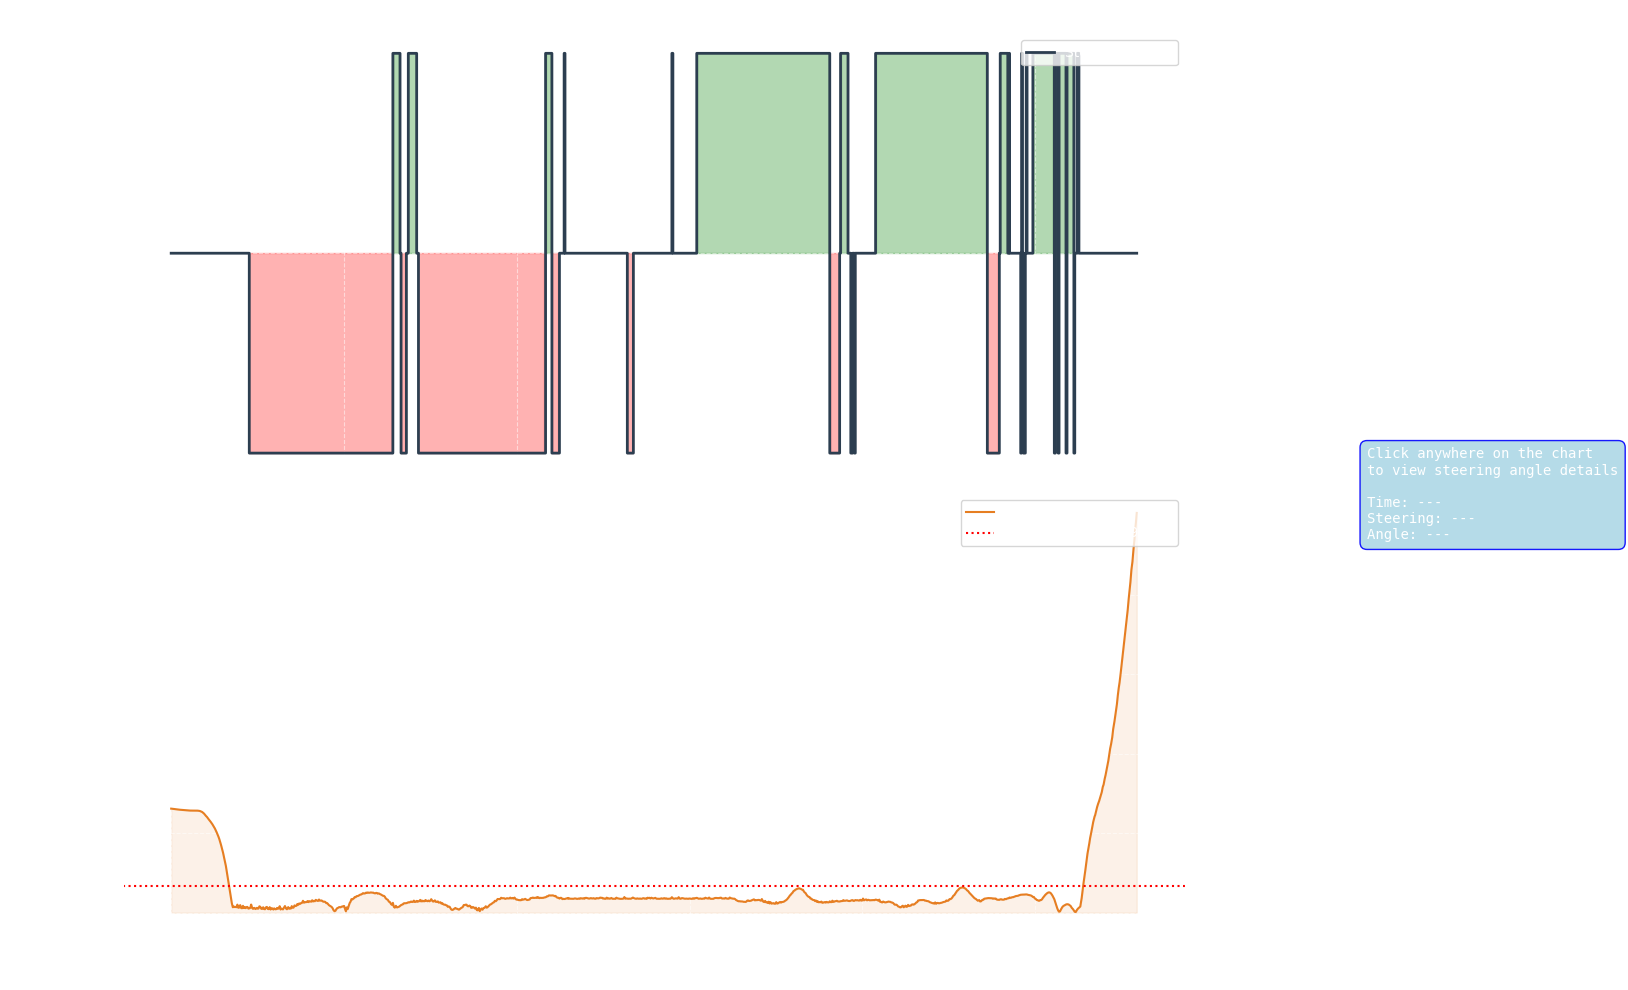


匹配误差统计：
最大偏差: 50.2578 米
平均偏差: 3.3289 米

转角统计信息：
最大左转角: 2.1018°
最大右转角: -1.4402°
平均转角: -0.0113°


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

def process_and_visualize_with_error(global_file, ego_file):
    """
    处理并可视化路径数据，包含转向识别、转角计算和路径匹配误差分析
    """

    # ===================== 第一部分：加载数据 =====================
    print("正在加载数据...")
    global_df = pd.read_csv(global_file)
    ego_df = pd.read_csv(ego_file)

    # ===================== 第二部分：转向识别与转角计算 =====================
    print("正在计算路径转向特征...")

    # 提取全局路径坐标
    global_coords = global_df[['global_x', 'global_y']].values

    # 计算相邻点之间的方向向量
    dx = np.diff(global_coords[:, 0])
    dy = np.diff(global_coords[:, 1])

    # 计算航向角（heading angle）
    headings = np.arctan2(dy, dx)

    # 计算航向角变化量（即转向角，单位：弧度）
    delta = np.diff(headings)

    # 处理角度跳变（避免从π到-π的突变）
    delta = (delta + np.pi) % (2 * np.pi) - np.pi

    # 将弧度转换为角度（单位：度）
    delta_degrees = np.degrees(delta)

    # 初始化转角数组（与原始数据长度一致）
    steering_angles = np.zeros(len(global_df))
    steering_angles[1:-1] = delta_degrees

    # 将转角信息添加到全局路径数据中
    global_df['steering_angle'] = steering_angles

    # 转向类型分类
    threshold = 0.008  # 转向阈值（弧度）
    conditions = [(steering_angles > threshold), (steering_angles < -threshold)]
    choices = [1, -1]  # 1=左转, -1=右转
    global_df['steering_type'] = np.select(conditions, choices, default=0)

    # ===================== 第三部分：KDTree路径匹配与误差计算 =====================
    print("正在进行 KDTree 匹配并计算距离误差...")

    # 构建KDTree索引
    tree = KDTree(global_coords)
    ego_coords = ego_df[['global_x', 'global_y']].values

    # 查询最近邻
    distances, indices = tree.query(ego_coords)

    # 更新自车数据
    ego_df['matched_index'] = indices
    ego_df['dist_error'] = distances / 2  # 匹配误差
    ego_df['current_steering'] = global_df['steering_type'].iloc[indices].values
    ego_df['current_angle'] = global_df['steering_angle'].iloc[indices].values

    # ===================== 第四部分：可视化展示 =====================
    print("正在生成可视化图表...")

    # 创建图形
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # 计算相对时间
    relative_time = ego_df['timestamp'] - ego_df['timestamp'].iloc[0]

    # -------------------- 子图1：转向状态 --------------------
    ax1.step(relative_time, ego_df['current_steering'], where='post',
             color='#2c3e50', linewidth=2, label='Steering Status')
    ax1.fill_between(relative_time, ego_df['current_steering'], 0,
                     where=(ego_df['current_steering'] > 0),
                     color='green', alpha=0.3, step='post')
    ax1.fill_between(relative_time, ego_df['current_steering'], 0,
                     where=(ego_df['current_steering'] < 0),
                     color='red', alpha=0.3, step='post')
    ax1.set_yticks([-1, 0, 1])
    ax1.set_yticklabels(['Right (-1)', 'Straight (0)', 'Left (1)'])
    ax1.set_ylabel('Steering Direction', fontsize=12)
    ax1.set_title('Steering Analysis & Map Matching Error (with Steering Angle Display)',
                  fontsize=14, fontweight='bold')
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.legend(loc='upper right')

    # -------------------- 子图2：匹配距离误差 --------------------
    ax2.plot(relative_time, ego_df['dist_error'],
             color='#e67e22', linewidth=1.5, label='Matching Distance Error')
    ax2.fill_between(relative_time, ego_df['dist_error'], 0,
                     color='#e67e22', alpha=0.1)

    # 平均误差线
    mean_error = ego_df['dist_error'].mean()
    ax2.axhline(mean_error, color='red', linestyle=':',
                label=f'Mean Error: {mean_error:.4f}m')

    ax2.set_xlabel('Time Offset (seconds)', fontsize=12)
    ax2.set_ylabel('Distance Error (meters)', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.legend(loc='upper right')

    # ===================== 第五部分：添加转角显示区域 =====================
    # 在图表右侧添加转角信息显示
    fig.subplots_adjust(right=0.85)  # 留出右侧空间

    # 创建转角显示的文本框位置
    angle_text_box = fig.text(0.98, 0.5, '',
                              transform=fig.transFigure,
                              fontsize=10,
                              verticalalignment='center',
                              bbox=dict(boxstyle='round,pad=0.5',
                                       facecolor='lightblue',
                                       edgecolor='blue',
                                       alpha=0.9),
                              family='monospace')

    # 转角显示更新函数
    def update_angle_text(event):
        if event.inaxes == ax1 or event.inaxes == ax2:
            # 获取鼠标点击位置对应的索引
            x_clicked = event.xdata
            idx = np.abs(relative_time.values - x_clicked).argmin()

            if 0 <= idx < len(ego_df):
                timestamp = ego_df['timestamp'].iloc[idx]
                steering = ego_df['current_steering'].iloc[idx]
                angle = ego_df['current_angle'].iloc[idx]

                # 转换转向类型为文字描述
                if steering == 1:
                    direction = 'Left'
                elif steering == -1:
                    direction = 'Right'
                else:
                    direction = 'Straight'

                # 更新文本框内容
                angle_text = f"""Timestamp: {timestamp:.4f}s
Steering: {direction} ({steering})
Angle: {angle:.4f}°

Index: {idx}
Distance Error: {ego_df['dist_error'].iloc[idx]:.4f}m"""
                angle_text_box.set_text(angle_text)
                fig.canvas.draw_idle()

    # 连接鼠标点击事件
    fig.canvas.mpl_connect('button_press_event', update_angle_text)

    # 添加初始提示信息
    initial_text = """Click anywhere on the chart
to view steering angle details

Time: ---
Steering: ---
Angle: ---"""
    angle_text_box.set_text(initial_text)

    plt.tight_layout()
    plt.subplots_adjust(right=0.85)  # 调整布局以显示右侧文本框
    plt.show()

    # ===================== 第六部分：统计信息打印 =====================
    print("\n匹配误差统计：")
    print(f"最大偏差: {ego_df['dist_error'].max():.4f} 米")
    print(f"平均偏差: {mean_error:.4f} 米")

    print("\n转角统计信息：")
    print(f"最大左转角: {ego_df['current_angle'].max():.4f}°")
    print(f"最大右转角: {ego_df['current_angle'].min():.4f}°")
    print(f"平均转角: {ego_df['current_angle'].mean():.4f}°")

    # 返回数据供进一步分析
    return global_df, ego_df


# ===================== 主程序执行 =====================
if __name__ == "__main__":
    # 执行处理和可视化
    global_data, ego_data = process_and_visualize_with_error(
        global_file='global_vehicle_data.csv',
        ego_file='ego_vehicle_data.csv'
    )


正在加载数据...
正在进行 KDTree 匹配并计算距离误差...


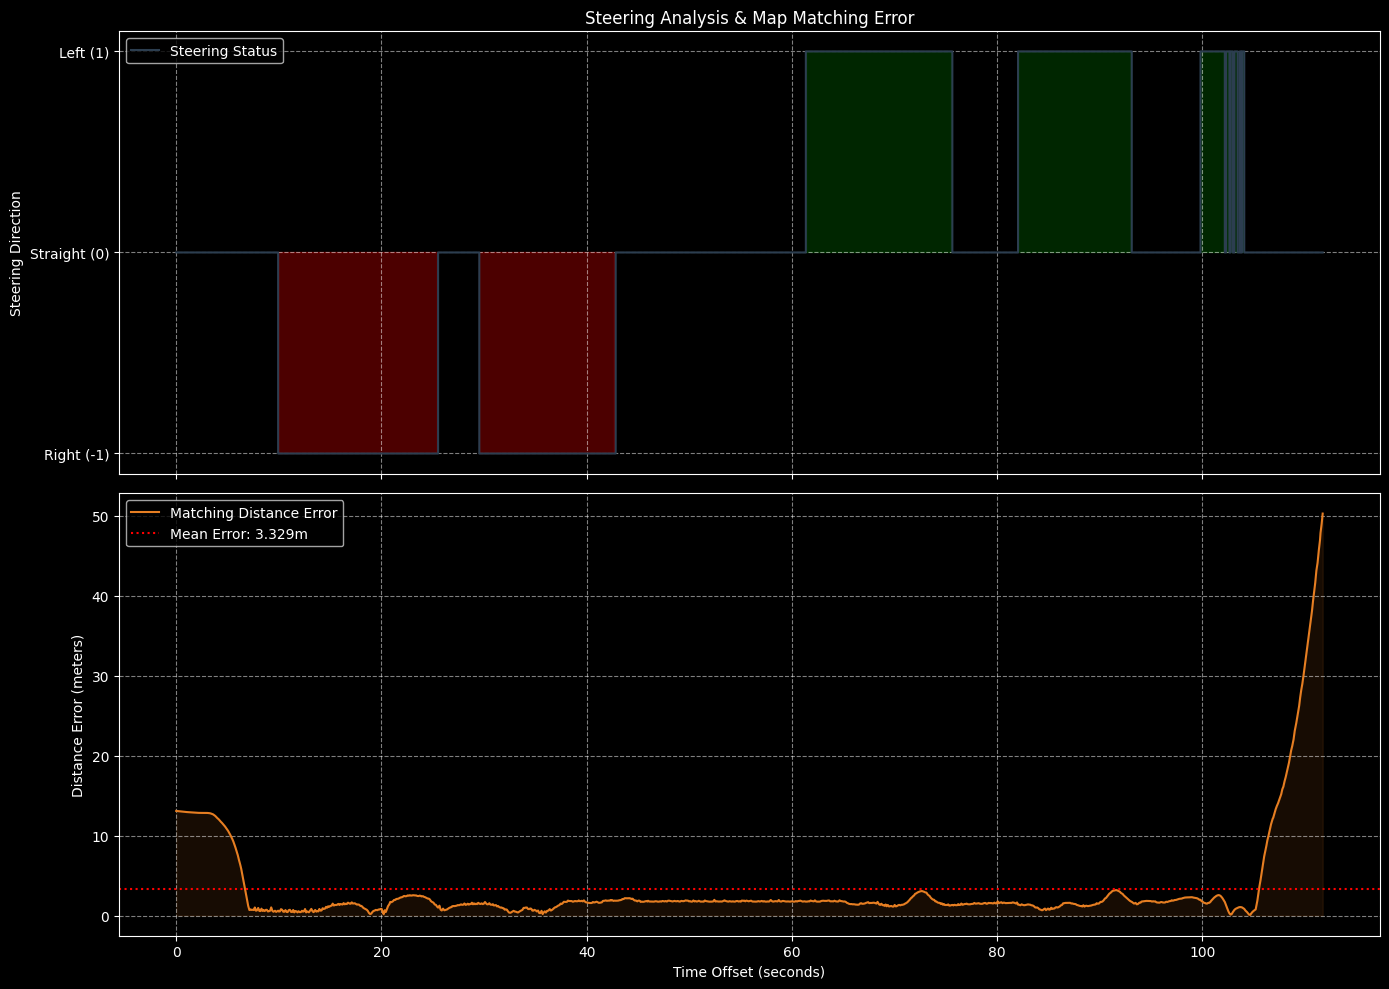


匹配误差统计：
最大偏差: 50.2578 米
平均偏差: 3.3289 米


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

def process_and_visualize_with_error(global_file, ego_file):
    # 1. 加载数据

    print("正在加载数据...")
    global_df = pd.read_csv(global_file)    # 读取两个csv文件
    ego_df = pd.read_csv(ego_file)

    # --- 第一部分：全局路径分析 (转向识别) ---

    global_coords = global_df[['global_x', 'global_y']].values

    dx = np.diff(global_coords[:, 0])

    dy = np.diff(global_coords[:, 1])

    headings = np.arctan2(dy, dx)



    delta = np.diff(headings)

    delta = (delta + np.pi) % (2 * np.pi) - np.pi # 处理角度跳变



    steering_deltas = np.zeros(len(global_df))

    steering_deltas[1:-1] = delta



    threshold = 0.008 # 转向阈值

    conditions = [(steering_deltas > threshold), (steering_deltas < -threshold)]

    choices = [1, -1]

    global_df['steering_type'] = np.select(conditions, choices, default=0)



    # --- 第二部分：KDTree 路径匹配与误差计算 ---

    print("正在进行 KDTree 匹配并计算距离误差...")

    tree = KDTree(global_coords)

    ego_coords = ego_df[['global_x', 'global_y']].values



    # distances: 自车点到最近全局路径点的欧式距离

    # indices: 对应的全局路径点索引

    distances, indices = tree.query(ego_coords)



    ego_df['matched_index'] = indices

    ego_df['dist_error'] = distances/2 # 匹配误差

    ego_df['current_steering'] = global_df['steering_type'].iloc[indices].values



    # --- 第三部分：可视化展示 ---

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    relative_time = ego_df['timestamp'] - ego_df['timestamp'].iloc[0]


    # 子图1：转向状态

    ax1.step(relative_time, ego_df['current_steering'], where='post', color='#2c3e50', label='Steering Status')

    ax1.fill_between(relative_time, ego_df['current_steering'], 0, where=(ego_df['current_steering'] > 0), color='green', alpha=0.3, step='post')

    ax1.fill_between(relative_time, ego_df['current_steering'], 0, where=(ego_df['current_steering'] < 0), color='red', alpha=0.3, step='post')

    ax1.set_yticks([-1, 0, 1])

    ax1.set_yticklabels(['Right (-1)', 'Straight (0)', 'Left (1)'])

    ax1.set_ylabel('Steering Direction')

    ax1.set_title('Steering Analysis & Map Matching Error')

    ax1.grid(True, linestyle='--', alpha=0.5)

    ax1.legend()

    # 子图2：匹配距离误差 (Distance Error)

    ax2.plot(relative_time, ego_df['dist_error'], color='#e67e22', linewidth=1.5, label='Matching Distance Error')

    # 填充误差区域

    ax2.fill_between(relative_time, ego_df['dist_error'], 0, color='#e67e22', alpha=0.1)



    # 绘制平均误差线

    mean_error = ego_df['dist_error'].mean()

    ax2.axhline(mean_error, color='red', linestyle=':', label=f'Mean Error: {mean_error:.3f}m')



    ax2.set_xlabel('Time Offset (seconds)')

    ax2.set_ylabel('Distance Error (meters)')

    ax2.grid(True, linestyle='--', alpha=0.5)

    ax2.legend()



    plt.tight_layout()

    plt.show()



    # 统计信息打印

    print("\n匹配误差统计：")

    print(f"最大偏差: {ego_df['dist_error'].max():.4f} 米")

    print(f"平均偏差: {mean_error:.4f} 米")



# 执行

process_and_visualize_with_error('global_vehicle_data.csv', 'ego_vehicle_data.csv')